In [1]:
# Import libraries
import os

# import functools
# print = functools.partial(print, flush=True)

In [2]:
# if os.environ.get("USE_GPU"):
#     import setGPU

In [3]:
import json
import timeit
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

# sklearn
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, f1_score
from sklearn.utils import class_weight
from sklearn.externals import joblib

/home/mantydze/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Configuration

data_base = "/home/mantydze/data" # no trailing slash

In [5]:
if os.environ.get("USE_EOS"):
    import getpass
    
    data_base = "/eos/user/m/mantydze/data" # no trailing slash
    
    #Authenticate in order to get permission for eos
    os.system("echo %s | kinit" % getpass.getpass())

In [6]:
# Read the dataset
dset_name = "SinglePhoton2016"

filename = "{data_base}/{dset_name}/single/{dset_name}.h5".format(data_base=data_base, dset_name=dset_name)

dset = None

with h5py.File(filename, "r") as f:
    dset = f[dset_name][:] 
        
print(dset.shape)

(128959, 2813)


In [7]:
# Feature extraction

# Feature 2807 - Run number
# Feature 2808 - Lumisection number

# #sort by run number and lumisection
# dset = dset[np.lexsort((dset[:, 2808], dset[:, 2807]))]

# Features
X = dset[:, :2807] # 2807 features

# Target
y = dset[:, 2812]

dset = None

In [8]:
# Feature scaling

X = StandardScaler(copy=False).fit_transform(X) # copy=False reduce memory usage

In [9]:
# Class balance
def print_unique(values):
    unique, counts = np.unique(values, return_counts=True)

    for cls, cnt in zip(unique, counts):
        print("Class [%d] Count [%d]" % (cls, cnt))
        
print_unique(y)

Class [0] Count [1578]
Class [1] Count [127381]


In [10]:
# Calculate class weights 
classes = np.unique(y)
weights = class_weight.compute_class_weight('balanced', classes, y)
cw = {int(cls): weight for cls, weight in zip(classes, weights)}

In [11]:
def print_split_info(X_train, y_train, X_test, y_test):
    
    # Train class balance
    unique, counts = np.unique(y_train, return_counts=True)
    train_balance = {int(k): v for k, v in zip(unique, counts)}
    
    # Test class balance
    unique, counts = np.unique(y_test, return_counts=True)
    test_balance = {int(k): v for k, v in zip(unique, counts)}
    
    # Train class weights
    classes = np.unique(y_train)
    weights = class_weight.compute_class_weight('balanced', classes, y_train)
    cw = {int(k): round(v, 2) for k, v in zip(classes, weights)}
    
    print("Train: size %d\t balance %s\t weights %s" % (len(X_train), train_balance, cw))
    print("Test : size %d\t balance %s" % (len(X_test), test_balance))

### Import model related libraries

In [12]:
# Boosted trees classifier
from xgboost import XGBClassifier

### Train

In [13]:
def train(X_train, y_train, verbose=True, **options):
    """ Returns trained model
    """
    start_time = timeit.default_timer()
    
    if verbose:
        print("Training", flush=True)
    
    # Model code starts here
    ############
    
    params = {
        "max_depth": 7, 
        "n_estimators": 64, 
#         "tree_method": "gpu_hist", 
#         "predictor": "gpu_predictor",
        "bin_size": 64,
        "nthread": 8
    }
    
    model = XGBClassifier(**params)
    
    # Train
    model.fit(X_train, y_train)
    
    ############
    # Model code ends here
    
    elapsed = timeit.default_timer() - start_time
    if verbose:
        print("Train time: %.1f s" % (elapsed))
        
    secs.append(elapsed)
    
    return model
    

### Evaluate

In [14]:
def evaluate(model, X_test, y_test, verbose=True):
    
    if verbose:
        print("Evaluating", flush=True)
        
    # Accuracy and f1_score
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    accs.append(acc)
    f1s.append(f1)
    
    roc_auc = -1
    if acc < 1:

        # ROC AUC
        y_probas = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probas)
        roc_auc = auc(fpr, tpr)

        aucs.append(roc_auc)
        fprs.append(fpr)
        tprs.append(tpr)
    
    if verbose:
        print(confusion_matrix(y_test, y_pred))
        print("acc: %.3f | f1: %.3f | auc: %.3f" % (acc, f1, roc_auc))

### Train & evaluate

In [15]:
%%time
n_splits = 10

accs = []
f1s = []

fprs = []
tprs = []
aucs = []
secs = []

skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)

for index, (train_indices, test_indices) in enumerate(skf.split(X, y)):
    print("Fold %d / %d" % ((index + 1), n_splits))
    
    # Generate batches from indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    print_split_info(X_train, y_train, X_test, y_test)
    
    model = train(X_train, y_train)
    
    evaluate(model, X_test, y_test)
    
    model = None # Release memory
    print()
    

Fold 1 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 386.5 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  230    86]
 [    4 25472]]
acc: 0.997 | f1: 0.998 | auc: 0.977

Fold 2 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 385.5 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  240    76]
 [    3 25473]]
acc: 0.997 | f1: 0.998 | auc: 0.973

Fold 3 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 384.4 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  234    82]
 [    3 25473]]
acc: 0.997 | f1: 0.998 | auc: 0.973

Fold 4 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 384.5 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  238    78]
 [    4 25472]]
acc: 0.997 | f1: 0.998 | auc: 0.980

Fold 5 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 373.4 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  244    72]
 [    2 25474]]
acc: 0.997 | f1: 0.999 | auc: 0.982

Fold 6 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 385.2 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  249    67]
 [    0 25476]]
acc: 0.997 | f1: 0.999 | auc: 0.982

Fold 7 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 384.9 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  253    63]
 [    4 25472]]
acc: 0.997 | f1: 0.999 | auc: 0.972

Fold 8 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 384.5 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  241    75]
 [    3 25473]]
acc: 0.997 | f1: 0.998 | auc: 0.968

Fold 9 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 385.5 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  242    74]
 [    5 25471]]
acc: 0.997 | f1: 0.998 | auc: 0.983

Fold 10 / 10
Train: size 103167	 balance {0: 1262, 1: 101905}	 weights {0: 40.87, 1: 0.51}
Test : size 25792	 balance {0: 316, 1: 25476}
Training
Train time: 383.1 s
Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  241    75]
 [    1 25475]]
acc: 0.997 | f1: 0.999 | auc: 0.978

CPU times: user 8h 23min 50s, sys: 1min 39s, total: 8h 25min 29s
Wall time: 1h 5min 8s


### Aggregate scores

In [16]:
d = dict(acc=np.array(accs), f1=np.array(f1s), auc=np.array(aucs), sec=np.array(secs))
scores = pd.DataFrame.from_dict(d, orient="index")
scores["mean"] = scores.mean(axis=1)
scores["std"] = scores.std(axis=1)

In [17]:
print(scores.transpose())

           acc        f1       auc         sec
0     0.996511  0.998236  0.976790  386.533685
1     0.996937  0.998452  0.972509  385.492918
2     0.996704  0.998334  0.973202  384.427029
3     0.996821  0.998393  0.979539  384.483976
4     0.997131  0.998550  0.981735  373.363845
5     0.997402  0.998687  0.981789  385.217057
6     0.997402  0.998687  0.971782  384.864921
7     0.996976  0.998471  0.967516  384.548673
8     0.996937  0.998452  0.982907  385.461097
9     0.997053  0.998511  0.978354  383.140528
mean  0.996987  0.998477  0.976612  383.753373
std   0.000266  0.000134  0.004887    3.563543


### Plot ROC AUC

/home/mantydze/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


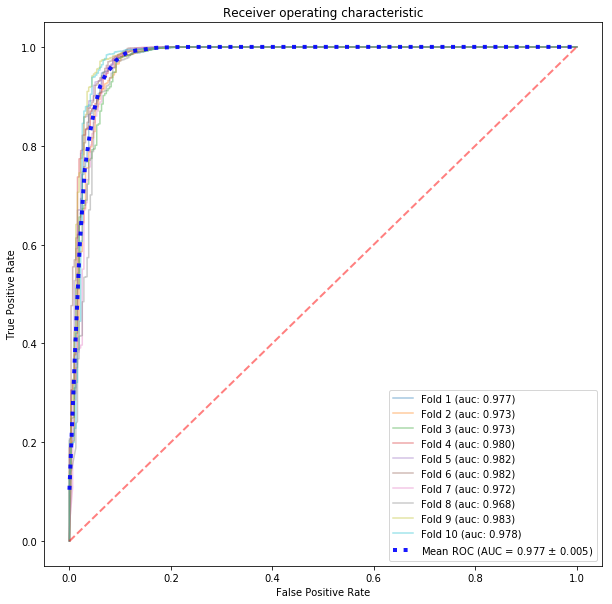

In [18]:
plt.figure(figsize=(10,10))

for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    plt.plot(fpr, tpr, label="Fold %d (auc: %.3f)" % ((i+1), aucs[i]), alpha=0.4)

tprs2 = []

mean_fpr = np.linspace(0, 1, 100)

for fpr, tpr in zip(fprs, tprs):
    tprs2.append(interp(mean_fpr, fpr, tpr))
    
mean_tpr = np.mean(tprs2, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 
         color="b",
         linestyle=":",
         linewidth=4,
         label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
         lw=2, alpha=.9)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.5)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Train and save model

In [19]:
X_train = X_test = y_train = y_test = None # Release memory
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = train(X_train, y_train)

Training
Train time: 373.8 s


In [21]:
evaluate(model, X_test, y_test)

Evaluating


/home/mantydze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[  245    84]
 [    2 25461]]
acc: 0.997 | f1: 0.998 | auc: 0.968


### Save

In [22]:
# Model
joblib.dump(model, "model.dat")

# Scores (acc, f1, auc)
with open("scores.json", "w") as outfile:
    data = scores.to_dict()
    json.dump(data, outfile, indent=4)

# Mean TPR, FPR, AUC, AUC STD
with open("roc.json", "w") as outfile:
    data = {
        "fpr": mean_fpr.tolist(), 
        "tpr":mean_tpr.tolist(), 
        "auc": mean_auc, 
        "std": std_auc
    }
    json.dump(data, outfile, indent=4)